# Decision Tree Regressor

### Theory

In this notebook, we will implement the CART algorithm for a decision tree regressor. The growth algorithm remains unchanged from that of the _DecisionTreeClassifier_, but our criteria to determine the best split is different. Rather than considering node puritiy via the Gini coefficient, we consider the sum of squared errors (SSE) of the children nodes. Specifically, the best split is one that minimises the SSE of the children node. Let us say that we split a parent node $P$ into the children nodes $C_L$ and $C_R$, the SSE resulting from this split is computed as,

$$\text{SSE} = \sum_{i \in C_L}^{N_L}(y_i - \bar{y}_{L})^{2} + \sum_{i \in C_R }^{N_R}(y_i - \bar{y}_{R})^{2}$$

In which, $P = C_L \cup C_R$ are the sets of data points contained within the parent and children nodes respectively. $\bar{y}_{L}$ and $\bar{y}_{R}$ are also the average of the targets within each node such that,

$$
\begin{array}{cc}
\bar{y}_{L} = \dfrac{1}{N_L}\sum\limits_{i}^{N_L}{y_i} & 
\bar{y}_{R} = \dfrac{1}{N_R}\sum\limits_{i}^{N_R}{y_i}
\end{array}
$$

With this in mind, our implementation of the _DecisionTreeRegressor_ is as follows,

In [2]:
# Importing,
import numpy as np

class DecisionTreeRegressor():

    def __init__(self, max_depth, min_samples_leaf=1, min_samples_split=2):
        """Constructor method for the DecisionTreeClassifier class. We simply create the class variables."""

        # Class variables for the data and nodes,
        self.X, self.y, self.nodes, self.leaves = None, None, None, None

        # Stopping criteria,
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        return None
    
    def fit(self, X, y):

        # Assignment to class attributes,
        self.X, self.y = X, y

        # Creating the root node,
        root_node = Node(self.X, self.y, node_name="O")
        self.nodes, self.leaves = [root_node], [root_node]

        # Growth algorithm,
        for i in range(self.max_depth):

            # Creating new layer,
            new_leaves = self._grow_tree()

            # Adding child nodes to list,
            self.nodes.extend(new_leaves)

        # Assigning predictions to leaves (terminate node),
        for leaf_node in self.leaves:
            leaf_node.prediction = np.mean(leaf_node.y)

    @staticmethod
    def _compute_SE(y_node):
        return np.sum((y_node - np.mean(y_node))**2)

    def _grow_tree(self):

        # Placeholder list,
        new_leaves = []

        # Looping through current leaves,
        for node in self.leaves:

            # If node has fewer than min_samples_split number of data point, we do not split,
            if len(node.y) < self.min_samples_split:
                continue

            # Performing split,
            child_node_left, child_node_right, valid_split = self._split(node.X, node.y, parent_node=node)

            if valid_split:
                # Assigning child nodes,
                node.child_left, node.child_right, = child_node_left, child_node_right

                # Appending nodes to list,
                new_leaves.extend([child_node_left, child_node_right])
            else: 
                # If no split occured, the node remains a leaf,
                new_leaves.append(node)

        # Updating leaves,
        self.leaves = new_leaves

        return new_leaves

    def _split(self, X, y, parent_node):
        """Binary splits a parent node into two child nodes based on the decision that mimises the SSE (sum of squared errors) of the
        child nodes."""

        # Placeholder variables,
        min_SSE = np.inf
        split_threshold_value = None
        found_valid_split = False
        X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = None, None, None, None

        # Double loop, first for each feature, second for each threshold value,
        for feature_idx in range(X.shape[1]):

            # Extracting feature values,
            X_feature = X[:, feature_idx]
            
            # Thresholds taken as the midpoint between sorted values,
            X_feature_sorted = np.sort(X_feature)
            thresholds = np.unique((X_feature_sorted[:-1] + X_feature_sorted[1:]) / 2)

            for threshold_value in thresholds:

                # Splitting data in parent node into child nodes,
                left_split_idxs, right_split_idxs = np.where(X_feature <= threshold_value)[0], np.where(X_feature > threshold_value)[0]
                X_left_split, X_right_split = X[left_split_idxs], X[right_split_idxs]
                y_left_split, y_right_split = y[left_split_idxs], y[right_split_idxs]

                # Reject splits which result in child nodes having less data points that the minimum number,
                if len(left_split_idxs) <= self.min_samples_leaf or len(right_split_idxs) <= self.min_samples_leaf:
                    continue
                else:
                    found_valid_split = True

                # Compute SSE of child nodes,
                children_SSE = self._compute_SE(y_node=y_left_split) + self._compute_SE(y_node=y_right_split)
            
                # Tracking minimum SSE,
                if children_SSE < min_SSE:
                    
                    # Reassigning minimum SSE,
                    min_SSE = children_SSE

                    # Updating nodes associated with the best split,
                    split_threshold_value, split_feature = threshold_value, feature_idx
                    X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = X_left_split, X_right_split, y_left_split, y_right_split

        # Creating node objects for the child nodes,
        if found_valid_split:
            left_name, right_name = parent_node.name + "L", parent_node.name + "R"
            child_node_left, child_node_right = Node(X_best_left_split, y_best_left_split, left_name), Node(X_best_right_split, y_best_right_split, right_name)
            parent_node.child_left, parent_node.child_right = child_node_left, child_node_right
            parent_node.decision = (split_feature, split_threshold_value)
            return child_node_left, child_node_right, True
        else:
            return None, None, False

    def predict(self, X):

        # Pre-allocating array for predictions
        n_samples = X.shape[0]
        preds = np.empty(shape=n_samples)

        # Looping over all samples,
        for i in range(n_samples):

            # Starting node is the root node,
            current_node = self.nodes[0]

            # Looping until we reach a terminal node (traversing the tree),
            while current_node.decision is not None:

                # Extracting decision,
                feature_idx, threshold_value = current_node.decision

                # Making the decision,
                if X[i, feature_idx] <= threshold_value:
                    current_node = current_node.child_left
                else:
                    current_node = current_node.child_right

            # Extracting prediction,
            preds[i] = current_node.prediction

        # Returning prediction from the terminal node,
        return preds
    
    def score(self, X, y):

        # Storing predictions as an array,
        y_preds = self.predict(X)

        # Computing R2 coefficient as the score,
        SS_res = np.sum((y - y_preds)**2)
        SS_total = np.sum((y - np.mean(y))**2)
        score = 1 - (SS_res/SS_total)

        return score

    def info(self):

        # Printing number of nodes,
        print(f"Number of Nodes: {len(self.nodes)}")

        # Printing node info,
        for node in self.nodes:
            node.info(verbose=True)

        return None

class Node():
    """The class for node objects. Essentially used as a container."""

    def __init__(self, X, y, node_name):
        """Constructor method for the node. Class variables contain node information and encode its location in the tree
        required for predictions."""

        # Node information,
        self.X, self.y = X, y
        self.decision = None
        self.prediction = None

        # Encodes location in the tree,
        self.name, self.child_left, self.child_right = node_name, None, None

    def info(self, verbose=False):
        """Returns information about the node."""

        if verbose:
            print(f"Node: {self.name}, Decision: {self.decision}, Prediction: {self.prediction}")

        return self.name, self.decision, self.prediction

In [1]:
# Importing,
import numpy as np

class DecisionTreeRegressor():

    def __init__(self, max_depth, min_samples_leaf=1, min_samples_split=2):
        """Constructor method for the DecisionTreeClassifier class. We simply create the class variables."""

        # Class variables for the data and nodes,
        self.X, self.y, self.tree_root = None, None, None

        # Stopping criteria,
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        return None
    
    def fit(self, X, y):

        # Assignment to class attributes,
        self.X, self.y = X, y

        # Growing the tree,
        self.tree_root = self._grow_tree(X=X, y=y, node_label="O", current_depth=1) # <-- The label "O" is for the root node.

        return None

    def _grow_tree(self, X, y, node_label, current_depth):
        """This function is recursively called and is responsible for the creation of the tree. The function is called every time we create a new node in the tree."""

        # Creating node object,
        current_node = Node(X, y, node_label)

        """STOPPING CRITERIA: maximum depth reached."""
        if current_depth == self.max_depth:

            # Marking as leaf node,
            current_node.is_leaf = True

            # Computing prediction for leaf node,
            current_node.prediction = self._compute_prediction(y_node=current_node.y)

            # Returning leaf node,
            return current_node

        # Splitting node,
        decision, children_data, node_labels, valid_split = self._split(X, y, parent_node=current_node)

        if valid_split: # <-- The case when we have a valid split.

            # Assigning decision to current node,
            current_node.decision = decision
        
            # Unpacking children data,
            X_left, X_right, y_left, y_right = children_data
            left_node_label, right_node_label = node_labels

            # Creating subtrees,
            current_depth += 1
            current_node.child_left = self._grow_tree(X=X_left, y=y_left, node_label=left_node_label, current_depth=current_depth) # <-- We grow the branch from the left node first.
            current_node.child_right = self._grow_tree(X=X_right, y=y_right, node_label=right_node_label, current_depth=current_depth) # <-- We backtrack and then grow the branches from the right nodes.

            # Returning our current node,
            return current_node

        else: #<-- The case when we do NOT have a valid split,

            # Our current node must be a leaf node,
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

    def _split(self, X, y, parent_node):
        """Binary splits a parent node into two child nodes based on the decision that mimises the SSE (sum of squared errors) of the
        child nodes."""

        # Placeholder variables,
        min_SSE = np.inf
        split_threshold_value = None
        found_valid_split = False
        X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = None, None, None, None

        # Double loop, first for each feature, second for each threshold value,
        for feature_idx in range(X.shape[1]):

            # Extracting feature values,
            X_feature = X[:, feature_idx]

            # Thresholds taken as the midpoint between sorted values,
            X_feature_sorted = np.sort(X_feature)
            thresholds = np.unique((X_feature_sorted[:-1] + X_feature_sorted[1:]) / 2)

            for threshold_value in thresholds:

                # Splitting data,
                left_split_idxs, right_split_idxs = np.where(X_feature <= threshold_value)[0], np.where(X_feature > threshold_value)[0]
                X_left_split, X_right_split = X[left_split_idxs], X[right_split_idxs]
                y_left_split, y_right_split = y[left_split_idxs], y[right_split_idxs]

                # Reject splits which result in child nodes having less data points that the minimum number,
                if len(left_split_idxs) <= self.min_samples_leaf or len(right_split_idxs) <= self.min_samples_leaf:
                    continue
                else:
                    found_valid_split = True

                # Compute SSE of child nodes,
                children_SSE = self._compute_SE(y_node=y_left_split) + self._compute_SE(y_node=y_right_split)
            
                # Tracking minimum SSE,
                if children_SSE < min_SSE:
                    
                    # Reassigning minimum SSE,
                    min_SSE = children_SSE

                    # Updating nodes associated with the best split,
                    split_threshold_value, split_feature = threshold_value, feature_idx
                    X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = X_left_split, X_right_split, y_left_split, y_right_split

        # Returning relevant data,
        if found_valid_split: # <-- Case 1: We have found a valid split.

            # Packaging data to return,
            node_labels = ((parent_node.label + "L"), (parent_node.label + "R"))
            decision = (split_feature, split_threshold_value)
            children_data = (X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split)

            # Assigning node decision,
            parent_node.decision = decision

            return decision, children_data, node_labels, found_valid_split
        else: #<-- Case 2: No valid split was found.
            return None, None, None, found_valid_split

    def score(self, X, y):

        # Storing predictions as an array,
        y_preds = self.predict(X)

        # Computing R2 coefficient as the score,
        SS_res = np.sum((y - y_preds)**2)
        SS_total = np.sum((y - np.mean(y))**2)
        score = 1 - (SS_res/SS_total)

        return score

    def _traverse_tree(self, node, current_depth=0, structure_preserved=True):
        """Traverses the tree via recursion."""

        if structure_preserved:
            indent = "  " * current_depth
            if node.is_leaf:
                print(f"{indent}Leaf → Predict: {node.prediction}")
            else:
                print(f"{indent}If X[:, {node.decision[0]}] <= {node.decision[1]}")
                self._traverse_tree(node.child_left, current_depth + 1)
                print(f"{indent}Else:")
                self._traverse_tree(node.child_right, current_depth + 1)
        else:
            print(f"Node: {node.label}, Decision: {node.decision}, Prediction: {node.prediction}")
            self._traverse_tree(node.child_left, current_depth + 1, structure_preserved=False)
            self._traverse_tree(node.child_right, current_depth + 1, structure_preserved=False)

    def print_tree(self, structure_preserved=True):
        tree_root = self.tree_root
        self._traverse_tree(node=tree_root, structure_preserved=structure_preserved)
        return None

    @staticmethod
    def _compute_prediction(y_node):
        return np.mean(y_node)

    @staticmethod
    def _compute_SE(y_node):
        return np.sum((y_node - np.mean(y_node))**2)

class Node():
    """The class for node objects. Essentially used as a container."""

    def __init__(self, X, y, node_label):
        """Constructor method for the node. Class variables contain node information and encode its location in the tree
        required for predictions."""

        # Node information,
        self.X, self.y = X, y
        self.is_leaf = False
        self.decision = None
        self.prediction = None

        # Encodes location in the tree,
        self.label, self.child_left, self.child_right = node_label, None, None

    def info(self, verbose=False):
        """Returns information about the node."""

        if verbose:
            print(f"Node: {self.label}, Decision: {self.decision}, Prediction: {self.prediction}")

        return self.label, self.decision, self.prediction

### Implementation

The boilerplate code for our implementation,

In [18]:
# Importing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Creating dataset,
iris_dataset = load_iris()
X = iris_dataset["data"][:, :3]
y = iris_dataset["data"][:, 3:4].flatten()

# Creating data split,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Creating model and fitting,
regressor = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=2)
regressor.fit(X_train, y_train)
regressor.info()
regressor.score(X_test, y_test)

Number of Nodes: 15
Node: O, Decision: (2, 2.45), Prediction: None
Node: OL, Decision: (0, 5.35), Prediction: None
Node: OR, Decision: (2, 4.7), Prediction: None
Node: OLL, Decision: (1, 3.5), Prediction: None
Node: OLR, Decision: (2, 1.45), Prediction: None
Node: ORL, Decision: (2, 4.0), Prediction: None
Node: ORR, Decision: (1, 3.2), Prediction: None
Node: OLLL, Decision: None, Prediction: 0.2333333333333333
Node: OLLR, Decision: None, Prediction: 0.18333333333333332
Node: OLRL, Decision: None, Prediction: 0.20000000000000004
Node: OLRR, Decision: None, Prediction: 0.33999999999999997
Node: ORLL, Decision: None, Prediction: 1.157142857142857
Node: ORLR, Decision: None, Prediction: 1.3913043478260867
Node: ORRL, Decision: None, Prediction: 1.9394736842105265
Node: ORRR, Decision: None, Prediction: 2.357142857142857


0.8936401333249685

Comparing this to sci-learn's implementation we see comparable performance,

0.9003367143759101


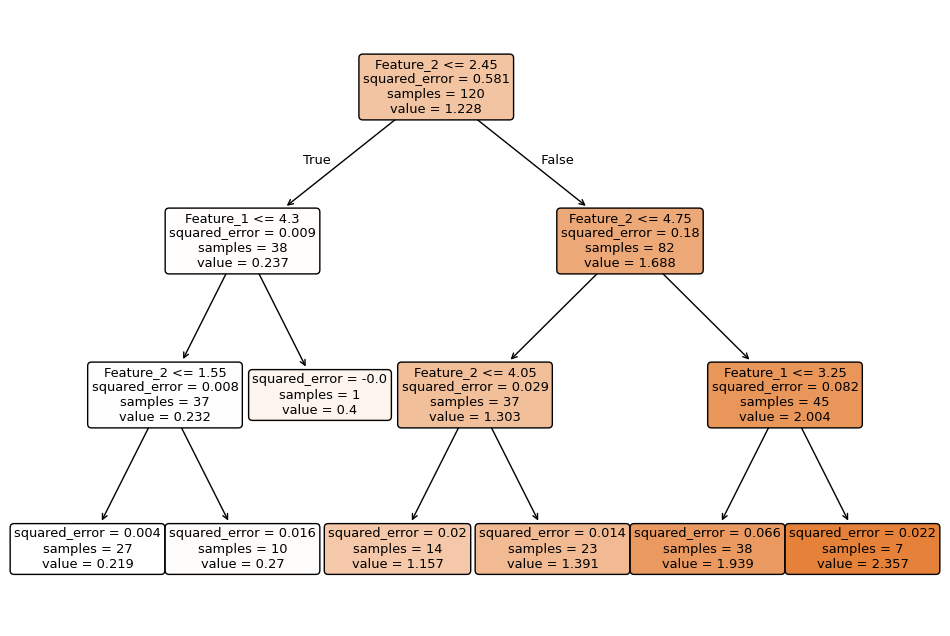

In [19]:
# Importing,
from sklearn.tree import DecisionTreeRegressor as SKDecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Creating model and fitting,
regressor = SKDecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=2)
regressor.fit(X_train, y_train)
print(regressor.score(X_test, y_test))

# Plotting,
plt.figure(figsize=(12, 8))
plot_tree(
    decision_tree=regressor,
    feature_names=['Feature_0', 'Feature_1', 'Feature_2'],
    filled=True,
    rounded=True
)
plt.show()

However, we do see that there is a slight discrepancy in predictive power in favour of the sci-learn implementation. Furthermore, there is a difference in the structure of the trees. Our implementation has more nodes and a different sub-tree from the left branch of the root node. We may explain these differences due to, 

1. **Split Selection Methodology**
   - Our Approach: Uses midpoint thresholds between sorted values, does not use tie-breaking rules and treats all features with equal importance.
   - Scikit-learn: Generates thresholds from histogram methods, tie-breaking rules are used and global feature importance is dynamically considerd when making splits.

2. **Pruning**
   - Our Approach: Does not implement pruning.
   - Scikit-learn: Implements cost-complexity pruning to remove redunant leaf nodes.

### Regression Example

As a last example, let us compare how well our model can perform regression for the curve $y = \sin{(X)}$ to sci-kit learn's standard implementation. 

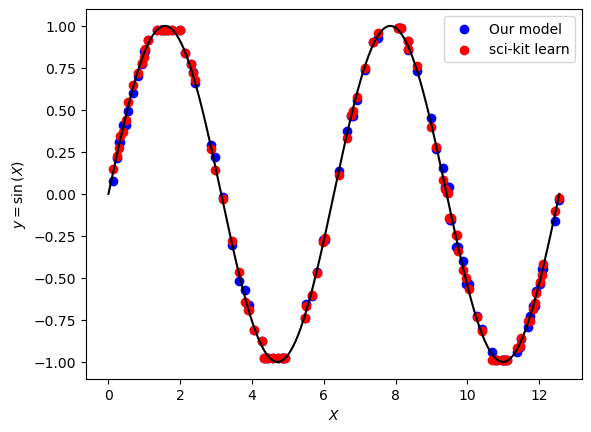

R2 (our model): 0.9980195443764682, R2 (sci-kit): 0.998802666441125


In [52]:
# Creating dataset,
X = np.linspace(start=0, stop=4*np.pi, num=500)
y = np.sin(X)
X = X.reshape(-1, 1) # <-- Transforming into correct shape.

# Creating data split,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Fitting the models,
regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2)
regressor.fit(X_train, y_train)
sk_regressor = SKDecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2)
sk_regressor.fit(X_train, y_train)

# Computing R2 score,
r2 = regressor.score(X_test, y_test)
sk_r2 = sk_regressor.score(X_test, y_test)

# Calculating predictions,
y_pred = regressor.predict(X_test)
y_pred_sk = sk_regressor.predict(X_test)

# Plotting,
plt.plot(X, y, color="black")
plt.scatter(X_test, y_pred, color="blue", label="Our model")
plt.scatter(X_test, y_pred_sk, color="red", label="sci-kit learn")
plt.ylabel(r"$y=\sin{(X)}$")
plt.xlabel(r"$X$")
plt.legend()
plt.show()

# Printing,
print(f"R2 (our model): {r2}, R2 (sci-kit): {sk_r2}")